In [2]:
from segment_anything import SamPredictor, sam_model_registry
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

import nibabel as nib
import imageio

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint="./checkpoints/sam_vit_h_4b8939.pth")
sam.to(device=DEVICE)
predictor = SamPredictor(sam)

In [29]:
# Fetch and turn .nii data to .png
# Data(label_btcv, label_tcia) from: https://zenodo.org/record/1169361#.ZFxRy9JByRQ
# Data(averaged series) from: https://aistudio.baidu.com/aistudio/datasetdetail/91106 , https://www.synapse.org/#!Synapse:syn3193805/wiki/217753
# May be abandoned if read .nii directly
 
def nii_to_image(niifile):
    filenames = os.listdir(filepath)
    slice_trans = []
 
    for f in filenames:
        img_path = os.path.join(filepath, f)
        img = nib.load(img_path)
        img_dobj = img.dataobj
        fname = f.replace('.nii','')
        img_f_path = os.path.join(imgfile, fname)
        if not os.path.exists(img_f_path):
            os.mkdir(img_f_path)

        (x,y,z) = img.shape
        
        for i in range(z):
            slice1 = img_dobj[:, :, i]
            imageio.imwrite(os.path.join(img_f_path,'{}.png'.format(i)), slice1)

# Need to put data in data folder first
if __name__ == '__main__':
    filepath = './data/averaged-training-images/' 
    imgfile = './data/train_label_png'
    nii_to_image(filepath)

In [3]:
# Utils
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [3]:
# SAM: generate masks

import cv2
from segment_anything import SamAutomaticMaskGenerator
import supervision as sv

mask_generator = SamAutomaticMaskGenerator(sam)

image_bgr = cv2.imread("./data/train_label_png/DET0000101_avg.gz/0.png")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

print(image_rgb.shape)
print(image_rgb.ndim)


sam_result = mask_generator.generate(image_rgb)

# print(sam_result[0].keys())


(192, 156, 3)
3


/home/vectorzhao/anaconda3/envs/sam/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


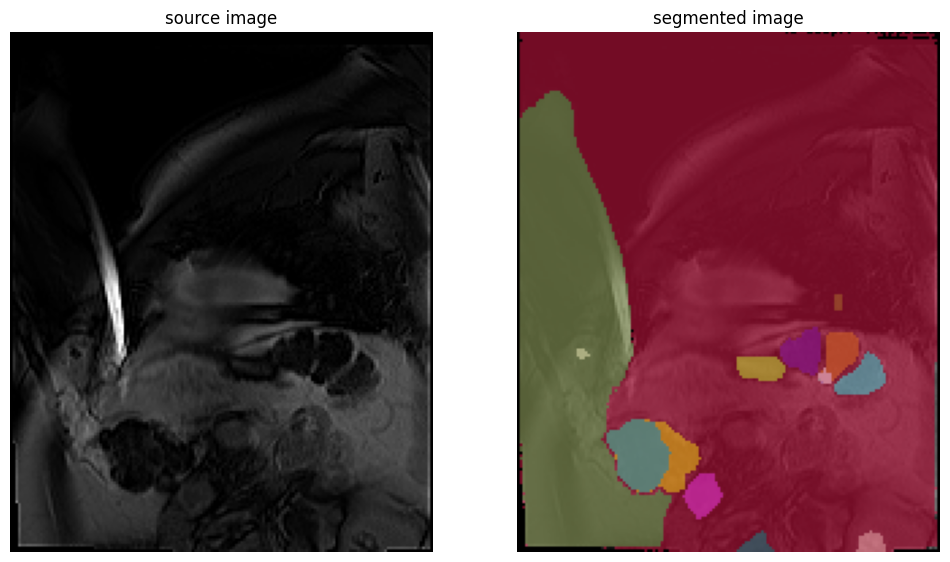

In [32]:
# Visualization with sv

mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

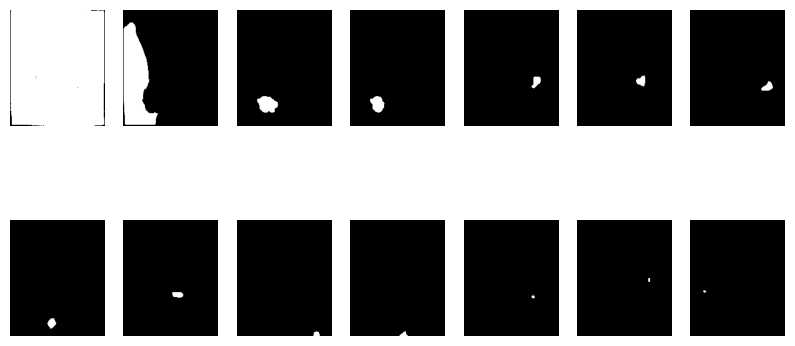

In [42]:
# Interaction with segmentation results

masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(2, int(len(masks) / 2)),
    size=(10, 5)
)

In [43]:
# SAM: Annotate segmentations on an image

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(sam_result)
annotated_image = mask_annotator.annotate(image_bgr, detections)

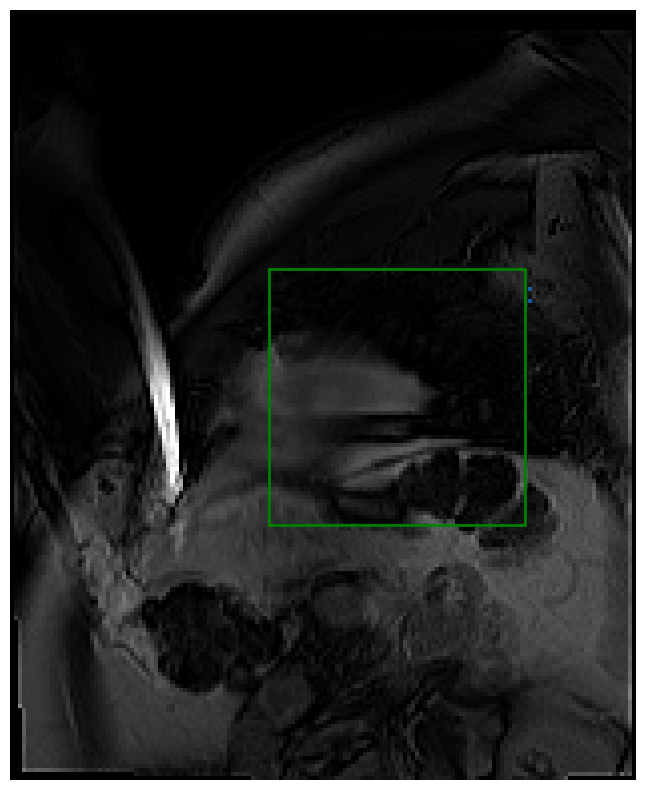

In [46]:
# SAM: Segment with bounding box
input_box = np.array([128, 64, 64, 128])
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()